---

# Problema de Negócio

Dados & Decotes, uma conceituada empresa de e-commerce que atua no ramo de moda masculina e feminina com roupas, calçados e acessórios, vem crescendo exponencialmente nos últimos anos e expandindo o seu estoque. Neste sentido, um dos desafios da varejista é conseguir otimizar os preços dos seus produtos de modo a maximizar o lucro nas vendas.

O sistema de precificação de produtos atual da empresa é dividido em duas etapas. Em um primeiro momento, é colocado uma margem de lucro sobre o preço de custo do produto. Exemplo: uma camisa que custa R\\$100,00 é vendida no varejo por R\\$150,00. Ou seja, apresenta uma margem de lucro de 50%.

Este método acaba acarretando em problemas de **subprecificação e sobreprecificação**, visto que nem todas as categorias de produtos comportam-se da mesma maneira em relação às vendas. Portanto, para resolver este problema, em um segundo momento, após 3 meses de avaliação do comportamento das vendas, são realizados cálculos de elasticidade de preço, onde de acordo com a quantidade demandada de cada produto o preço de venda também é ajustado, de modo a alcançar o maior faturamento possível.

Devido ao processo de expansão da empresa e da grande quantidade de novos produtos adquiridos, a ideia dos gestores é implantar uma terceira etapa de precificação, onde o preço dos produtos novos e recém lançados no mercado deve ser otimizado com base nas suas características, tais como marca, categoria, tecido e outras. Entretanto, os dados históricos disponíveis estão completamente bagunçados e em formato de arquivo .json.

## Objetivo

Como analistas e cientistas de dados da Dados & Decotes, o desafio da sua equipe é encontrar quais deveriam ser estes novos preços, com base neste conjunto histórico de dados contendo os preços e as características dos produtos que alcançaram o maior sucesso nas vendas decorrente dos cálculos de elasticidade de preço.

# 0.0 Imports

In [31]:
import pandas as pd
import numpy as np
import ast

import matplotlib.pyplot as plt
import seaborn as sns

#import sweetviz as sv

from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split
import sklearn.cluster as ct
import sklearn.metrics as mt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error 


import inflection

plt.style.use('ggplot')
sns.set_style('darkgrid')

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

import warnings

warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [32]:
def clean_test(X_test_2):
    X_test_2['product_details_count'] = X_test_2['product_details'].apply(lambda x: len(ast.literal_eval(x)) )
    X_test_2['product_details'] = X_test_2['product_details'].apply(lambda x: ast.literal_eval(x))

    all_keys = set()
    for data in X_test_2['product_details']:
        for item in data:
            all_keys.update(item.keys())
    
    # Para cada chave no conjunto, crie uma coluna no DataFrame e preencha com os valores correspondentes
    for key in all_keys:
        X_test_2[key] = X_test_2['product_details'].apply(lambda x: next((item[key] for item in x if key in item), np.nan))
    
    # Remova a coluna 'product_details' original
    X_test_2.drop('product_details', axis=1, inplace=True)

    X_test_2.rename(columns={'Pack of': 'Pack Of 2'}, inplace=True)
    
    # Preencha os valores NaN na coluna 'Pack Of' com os valores da coluna 'Pack Of' 2
    X_test_2['Pack Of'].fillna(X_test_2['Pack Of 2'], inplace=True)
    
    X_test_2.drop('Pack Of 2', axis=1, inplace=True)

    details_to_maintain_test = ['pid', '_id',
                       'average_rating',
                       'number_of_reviews',
                       'brand',
                       'category',
                       'crawled_at',
                       'description',
                       'images',
                       'out_of_stock',
                       'avg_delivery_time_days',
                       'pid',
                       'seller',
                       'sub_category',
                       'fabrication_time',
                       'title',
                       'product_details_count',
                       "Fabric",
                        "Fabric Care",
                        "Hooded",
                        "Pockets",
                        "Pack Of",
                        "Secondary Color",
                        "Style Code",
                        "Ideal For",
                        "Reversible",
                        "Neck",
                        "Generic Name",
                        "Brand Fit",
                        "Pattern",
                        "Sleeve",
                        "Country of Origin",
                        "Size",
                        "Fit",
                        "Number of Contents in Sales Package",
                        "Suitable For",
                        "Occasion",
                        "Color",
                        "Neck Type",
                        'Type']
    X_test_2 = X_test_2[details_to_maintain_test]

    X_test_2['images'] = X_test_2['images'].apply(lambda x: ast.literal_eval(x))
    X_test_2['number_images'] = X_test_2['images'].apply(lambda x: len(x))

    #Coluna Fabric
    X_test_2['has_cotton']    = X_test_2['Fabric'].str.contains('cott', case=False, na=False)
    X_test_2['has_polyester'] = X_test_2['Fabric'].str.contains('poly', case=False, na=False)
    X_test_2['has_lycra']     = X_test_2['Fabric'].str.contains('lycr', case=False, na=False)
    
    #Coluna Brand Fit
    X_test_2['is_regular'] = X_test_2['Brand Fit'].str.contains('reg', case=False, na=False)
    X_test_2['is_slim']    = X_test_2['Brand Fit'].str.contains('slim', case=False, na=False)
    X_test_2['is_fit']     = X_test_2['Brand Fit'].str.contains('fit', case=False, na=False)

    cols_drop = ['_id','crawled_at','description','title','images']
    X_test_2 = X_test_2.drop(cols_drop, axis=1)

    X_test_2 = X_test_2.fillna(0)

    te_cols = ['brand','seller','sub_category',"Fabric",
                        "Fabric Care",
                        "Hooded",
                        "Pockets",
                        "Pack Of",
                        "Secondary Color",
                        "Style Code",
                        "Ideal For",
                        "Reversible",
                        "Neck",
                        "Generic Name",
                        "Brand Fit",
                        "Pattern",
                        "Sleeve",
                        "Country of Origin",
                        "Size",
                        "Fit",
                        "Number of Contents in Sales Package",
                        "Suitable For",
                        "Occasion",
                        "Color",
                        "Neck Type",
                        "Type"]
    
    X_test_2 = pd.get_dummies(X_test_2, columns=onehot)

    X_test_2[te_cols] = X_test_2[te_cols].astype(str)
    X_test_2[te_cols] = te.transform(X_test_2[te_cols])

    
    X_test_2 = X_test_2.drop(['pid'], axis=1).copy()
    X_test_2.columns = X_test_2.columns.map(lambda x: inflection.parameterize(x, separator='_'))

    return X_test_2
    
def smape(y_pred, y_test):

    smape = 100 / len(y_test) * np.sum(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred)))
    return smape

def compute_metrics(model_name, y_pred, y_test):

    y_pred = np.expm1(y_pred)
    y_test = np.expm1(y_test)
                     

    smape = 100 / len(y_test) * np.sum(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred)))
    mae =mean_absolute_error(y_pred, y_test)
    mape = mean_absolute_percentage_error(y_pred, y_test)
    rmse = mean_squared_error(y_pred, y_test, squared=False)

    df = pd.DataFrame({
        'Model':model_name,
        'MAE':mae,
        'MAPE':mape,
        'RMSE':rmse,
        'SMAPE':smape
    }, index=[0])

    return df

def make_submission(X_test_2, y_pred_test):
    
    test_raw = pd.read_json(path + 'test.json', orient='split')
    X_test_submission = X_test_2.copy()
    X_test_submission['pid'] = test_raw['pid']
    X_test_submission['actual_price'] = y_pred_test
    df_submission = X_test_submission[['pid','actual_price']]

    return df_submission

## 0.2 Load Data

In [33]:
path = '/home/edilson07/projects/hackday_6/datasets/'

df_raw = pd.read_json(path + 'train.json', orient='split')

# 1.0 Data Description

In [34]:
df_raw.head(3)

,_id,average_rating,number_of_reviews,brand,category,crawled_at,description,images,out_of_stock,avg_delivery_time_days,pid,product_details,seller,sub_category,fabrication_time,title,actual_price
0,53df9662-e500-569c-946e-0c8d215a72cd,3.2,26,East I,Clothing and Accessories,2021-02-10 21:17:28,Navy Blue Printed Boxers Has An Inner Elasti...,['https://rukminim1.flixcart.com/image/128/128...,False,8,BXRFTZF7JGX75DAW,"[{'Color': 'Dark Blue'}, {'Fabric': 'Pure Cott...",ZIYAA,Innerwear and Swimwear,653,Printed Men Boxer (Pack of 1),849.0
1,d0142842-84f7-537d-a06f-d85b76488a5f,4.0,33,dream o,Clothing and Accessories,2021-02-11 01:02:46,smiley printed tshirt on round neck cotton tshirt,['https://rukminim1.flixcart.com/image/128/128...,False,12,TSHFWQM96UHR6A4Q,"[{'Type': 'Round Neck'}, {'Sleeve': 'Short Sle...",Dream Onn Creations,Topwear,668,Printed Men Round Neck Orange T-Shirt,699.0
2,79c8f0d7-30b1-5dd4-9f2f-2fe97782b027,3.9,32,Free Authori,Clothing and Accessories,2021-02-11 00:43:37,Free Authority Presents this Crew Neck Yellow ...,['https://rukminim1.flixcart.com/image/128/128...,False,11,SWSFWCXH2WF6ZYRB,"[{'Color': 'Yellow'}, {'Fabric': 'Polycotton'}...",BioworldMerchandising,Winter Wear,53,Full Sleeve Graphic Print Men Sweatshirt,1499.0


In [35]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23309 entries, 0 to 23308
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   _id                     23309 non-null  object        
 1   average_rating          23309 non-null  float64       
 2   number_of_reviews       23309 non-null  int64         
 3   brand                   23309 non-null  object        
 4   category                23309 non-null  object        
 5   crawled_at              23309 non-null  datetime64[ns]
 6   description             23309 non-null  object        
 7   images                  23309 non-null  object        
 8   out_of_stock            23309 non-null  bool          
 9   avg_delivery_time_days  23309 non-null  int64         
 10  pid                     23309 non-null  object        
 11  product_details         23309 non-null  object        
 12  seller                  23309 non-null  object     

In [36]:
df_raw.describe()

,average_rating,number_of_reviews,crawled_at,avg_delivery_time_days,fabrication_time,actual_price
count,23309.000000,23309.000000,23309,23309.000000,23309.000000,19813.000000
mean,3.367322,27.767386,2021-02-10 22:55:49.561242624,9.933502,366.663563,1480.980568
min,0.000000,0.000000,2021-02-10 20:11:51,3.000000,1.000000,150.000000
25%,3.100000,26.000000,2021-02-10 21:30:50,7.000000,184.000000,895.000000
50%,3.700000,31.000000,2021-02-10 23:01:37,10.000000,369.000000,1256.000000
75%,4.100000,34.000000,2021-02-11 00:17:54,13.000000,550.000000,1799.000000
max,5.000000,41.000000,2021-02-11 01:31:55,19.000000,729.000000,12999.000000
std,1.157570,9.555809,NaN,3.568971,210.255811,967.824650


In [37]:
df_raw.nunique()

_id                       23309
average_rating               39
number_of_reviews            33
brand                       307
category                      4
crawled_at                15293
description                4318
images                    19089
out_of_stock                  2
avg_delivery_time_days       17
pid                       21951
product_details           20955
seller                      483
sub_category                 24
fabrication_time            729
title                      3973
actual_price                636
dtype: int64

# 2.0 Feature Engineering

In [38]:
df1 = df_raw.copy()

## 2.1 Coluna Product Details

In [39]:
df1['product_details_count'] = df1['product_details'].apply(lambda x: len(ast.literal_eval(x)) )

### Transformar detalhes dos produtos em colunas

In [40]:
df1['product_details'] = df1['product_details'].apply(lambda x: ast.literal_eval(x))

In [41]:
all_keys = set()
for data in df1['product_details']:
    for item in data:
        all_keys.update(item.keys())

# Para cada chave no conjunto, crie uma coluna no DataFrame e preencha com os valores correspondentes
for key in all_keys:
    df1[key] = df1['product_details'].apply(lambda x: next((item[key] for item in x if key in item), np.nan))
    

# Remova a coluna 'product_details' original
df1.drop('product_details', axis=1, inplace=True)

In [42]:
df1.rename(columns={'Pack of': 'Pack Of 2'}, inplace=True)

# Preencha os valores NaN na coluna 'Pack Of' com os valores da coluna 'Pack Of' 2
df1['Pack Of'].fillna(df1['Pack Of 2'], inplace=True)

df1.drop('Pack Of 2', axis=1, inplace=True)

### Selecionar Os Melhores 

In [43]:
df1.isna().sum()

_id                                        0
average_rating                             0
number_of_reviews                          0
brand                                      0
category                                   0
crawled_at                                 0
description                                0
images                                     0
out_of_stock                               0
avg_delivery_time_days                     0
pid                                        0
seller                                     0
sub_category                               0
fabrication_time                           0
title                                      0
actual_price                            3496
product_details_count                      0
                                       23073
Lining                                 23268
Pleated                                23308
Coat Type                              23305
Height                                 23306
Fastener  

In [44]:
count_nan = pd.DataFrame(df1.isna().sum()).rename(columns={0:'Numero NaN'})
count_nan.loc[count_nan['Numero NaN'] < 20000,:]

,Numero NaN
_id,0
average_rating,0
number_of_reviews,0
brand,0
category,0
crawled_at,0
description,0
images,0
out_of_stock,0
avg_delivery_time_days,0


In [45]:
details_to_maintain = ['pid', '_id',
                       'average_rating',
                       'number_of_reviews',
                       'brand',
                       'category',
                       'crawled_at',
                       'description',
                       'images',
                       'out_of_stock',
                       'avg_delivery_time_days',
                       'seller',
                       'sub_category',
                       'fabrication_time',
                       'title',
                       'actual_price',
                       'product_details_count',
                       "Fabric",
                        "Fabric Care",
                        "Hooded",
                        "Pockets",
                        "Pack Of",
                        "Secondary Color",
                        "Style Code",
                        "Ideal For",
                        "Reversible",
                        "Neck",
                        "Generic Name",
                        "Brand Fit",
                        "Pattern",
                        "Sleeve",
                        "Country of Origin",
                        "Size",
                        "Fit",
                        "Number of Contents in Sales Package",
                        "Suitable For",
                        "Occasion",
                        "Color",
                        "Neck Type",
                        "Type"]


df1 = df1[details_to_maintain]

## 2.2 Criar colunas Numero de Imagens

In [46]:
df1['images'] = df1['images'].apply(lambda x: ast.literal_eval(x))

In [47]:
df1['number_images'] = df1['images'].apply(lambda x: len(x))
df1 = df1.drop(['images'],axis=1)

## 2.3 Criar Colunas Baseado nos Tecidos e no Tamanho

In [48]:
#Coluna Fabric
df1['has_cotton']    = df1['Fabric'].str.contains('cott', case=False, na=False)
df1['has_polyester'] = df1['Fabric'].str.contains('poly', case=False, na=False)
df1['has_lycra']     = df1['Fabric'].str.contains('lycr', case=False, na=False)

#Coluna Brand Fit
df1['is_regular'] = df1['Brand Fit'].str.contains('reg', case=False, na=False)
df1['is_slim']    = df1['Brand Fit'].str.contains('slim', case=False, na=False)
df1['is_fit']     = df1['Brand Fit'].str.contains('fit', case=False, na=False)

## 2.4 Preencher NaNs

In [49]:
df1 = df1.dropna(subset='actual_price')

In [50]:
df1 = df1.fillna(0)

In [51]:
df1.isna().sum()

pid                                    0
_id                                    0
average_rating                         0
number_of_reviews                      0
brand                                  0
category                               0
crawled_at                             0
description                            0
out_of_stock                           0
avg_delivery_time_days                 0
seller                                 0
sub_category                           0
fabrication_time                       0
title                                  0
actual_price                           0
product_details_count                  0
Fabric                                 0
Fabric Care                            0
Hooded                                 0
Pockets                                0
Pack Of                                0
Secondary Color                        0
Style Code                             0
Ideal For                              0
Reversible      

In [52]:
df1.nunique()

pid                                    18718
_id                                    19813
average_rating                            38
number_of_reviews                         32
brand                                    301
category                                   3
crawled_at                             13940
description                             3903
out_of_stock                               2
avg_delivery_time_days                    17
seller                                   460
sub_category                              23
fabrication_time                         729
title                                   3580
actual_price                             636
product_details_count                     25
Fabric                                   198
Fabric Care                              422
Hooded                                     3
Pockets                                   98
Pack Of                                   14
Secondary Color                           51
Style Code

# 3.0 EDA

## Analise Univariada

In [53]:
numerical_feat = df1.select_dtypes(include=['float','int'])
categorical_feat = df1.select_dtypes(exclude=['float','int','datetime'])

array([[<Axes: title={'center': 'average_rating'}>,
        <Axes: title={'center': 'number_of_reviews'}>,
        <Axes: title={'center': 'avg_delivery_time_days'}>],
       [<Axes: title={'center': 'fabrication_time'}>,
        <Axes: title={'center': 'actual_price'}>,
        <Axes: title={'center': 'product_details_count'}>],
       [<Axes: title={'center': 'number_images'}>, <Axes: >, <Axes: >]],
      dtype=object)

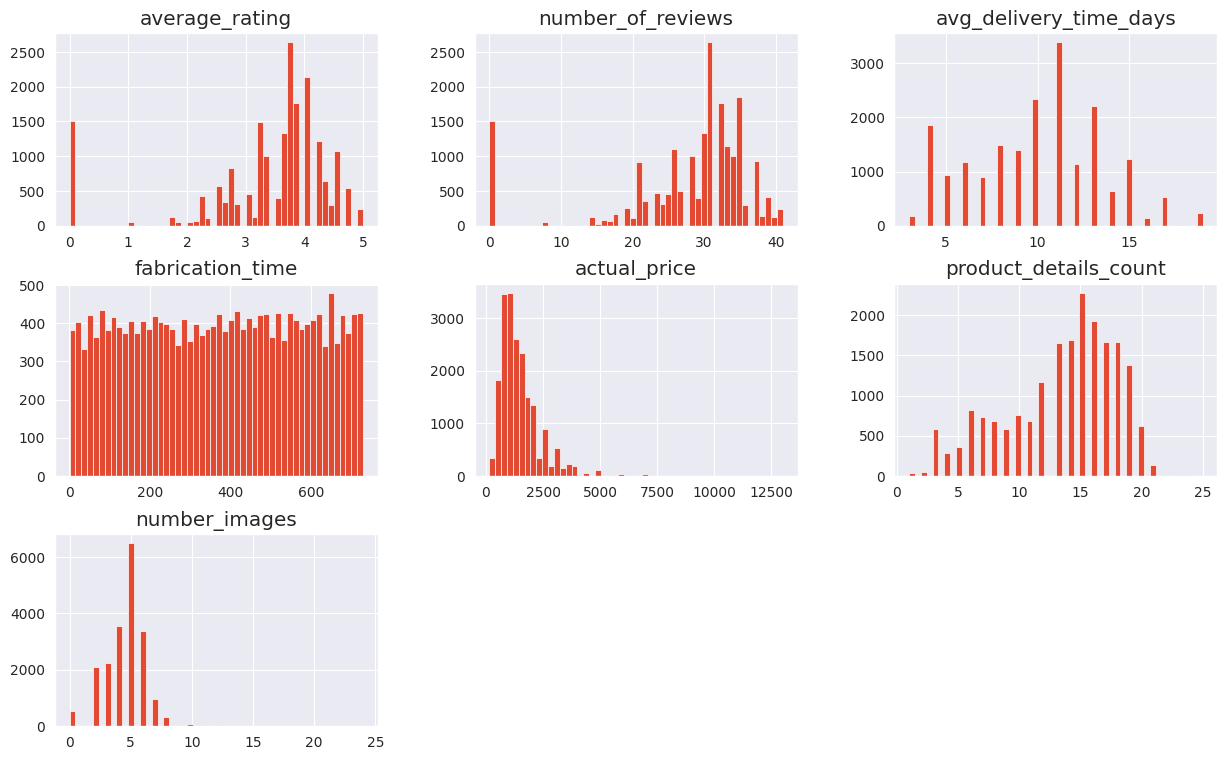

In [54]:
numerical_feat.hist(bins=50, figsize=(15,9))

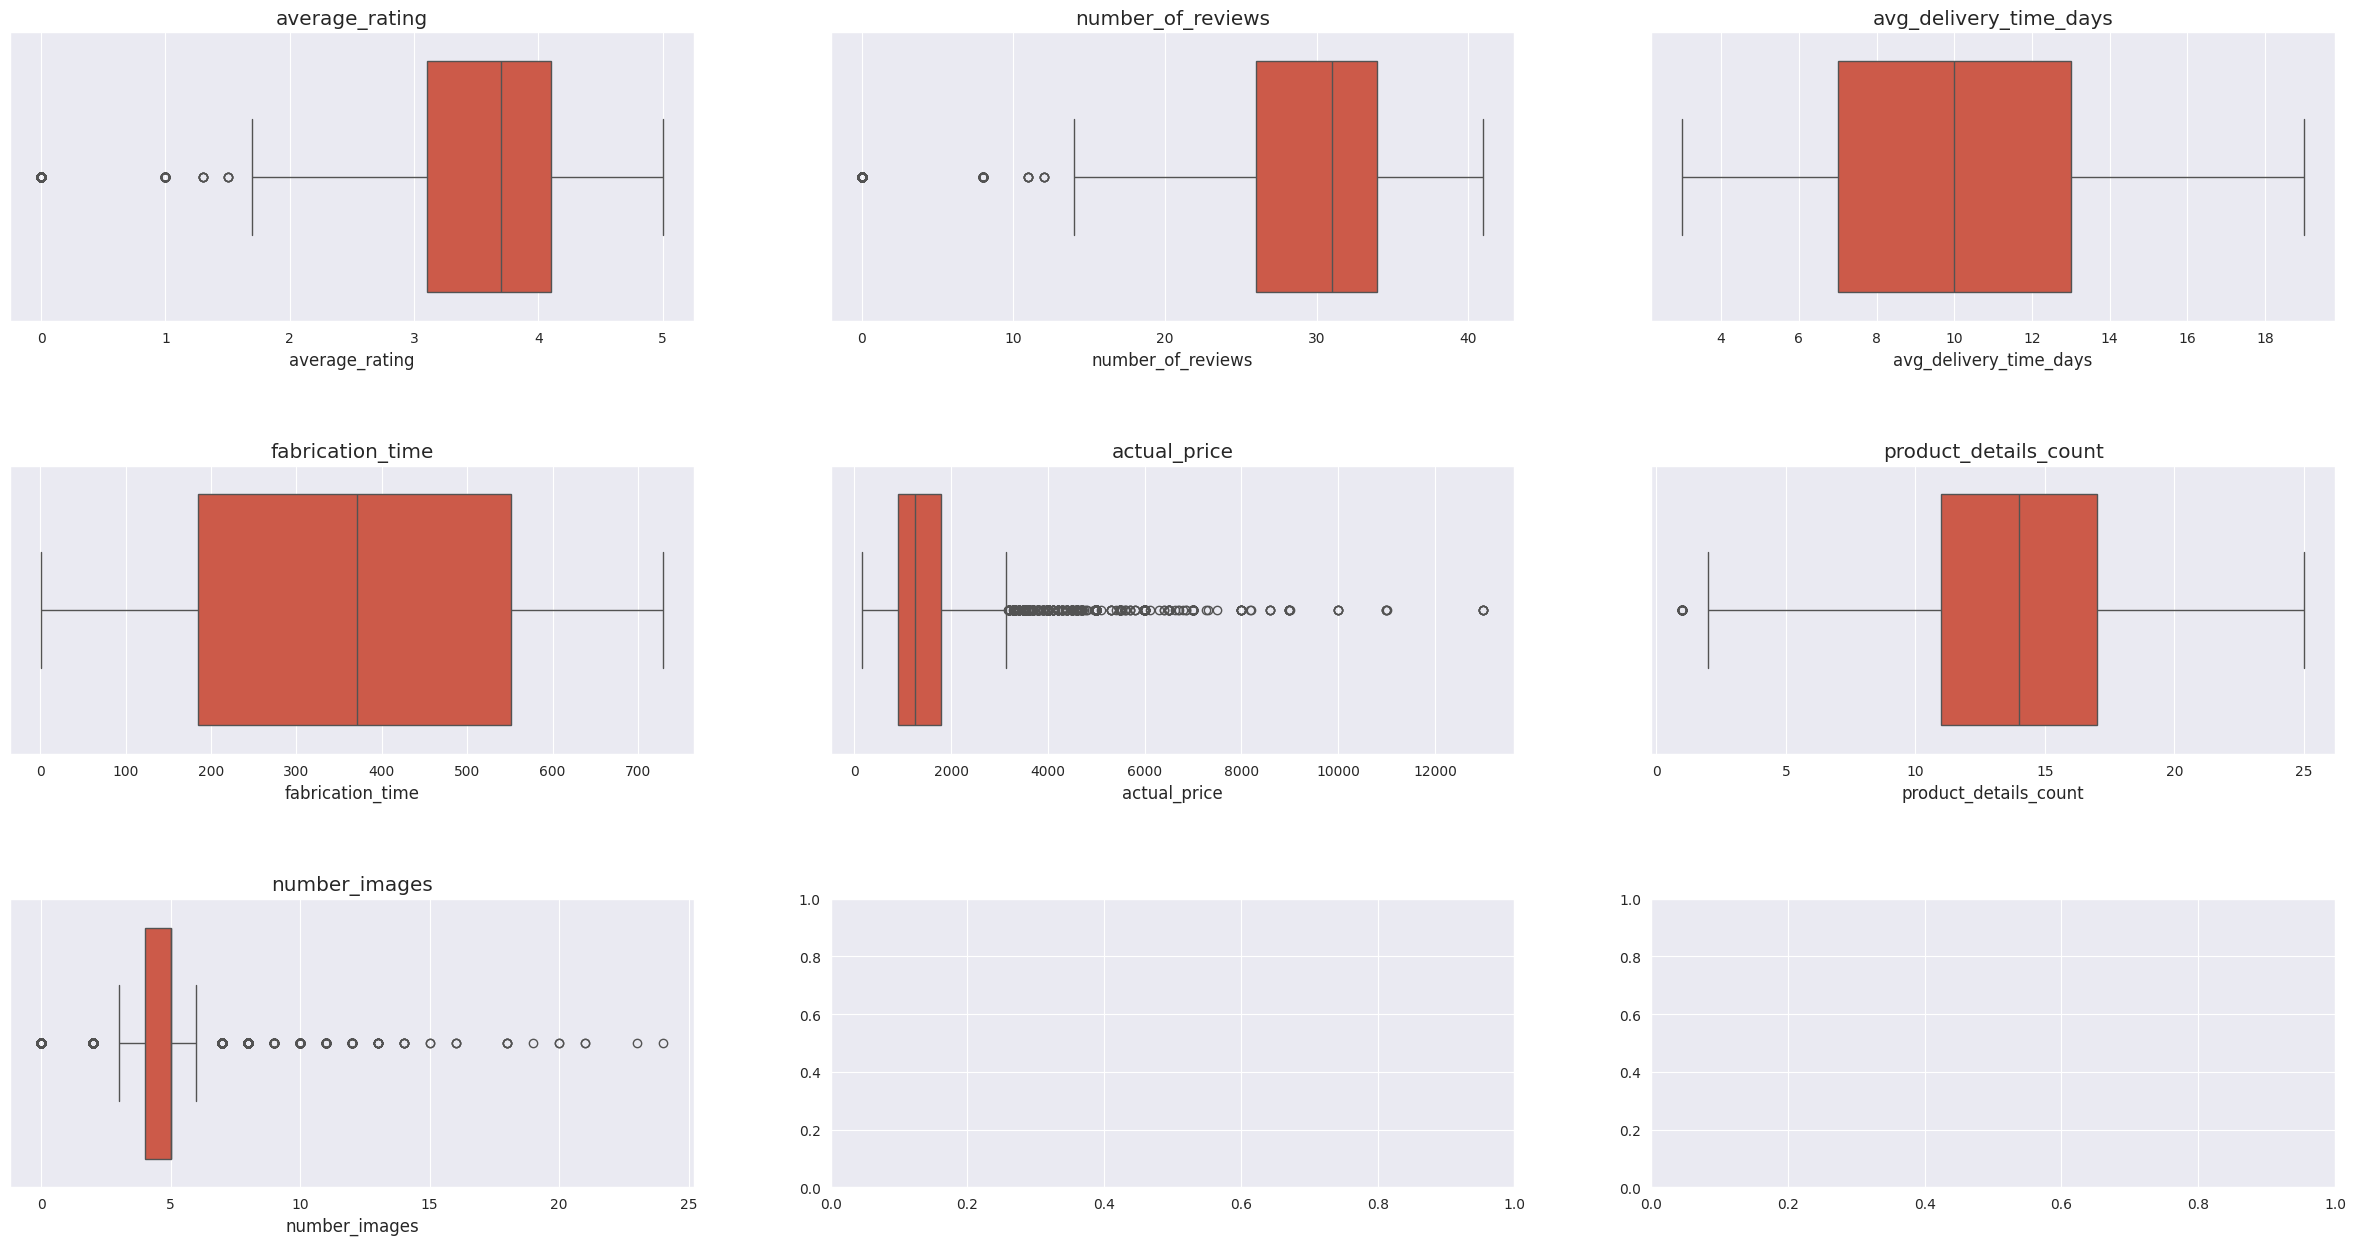

In [55]:
columns_to_plot = numerical_feat.columns

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 15))
fig.subplots_adjust(hspace=0.5)

for i, column in enumerate(columns_to_plot):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    sns.boxplot(df1, x=column, ax=ax)
    ax.set_title(column)

plt.show()

## Bivariate Analysis

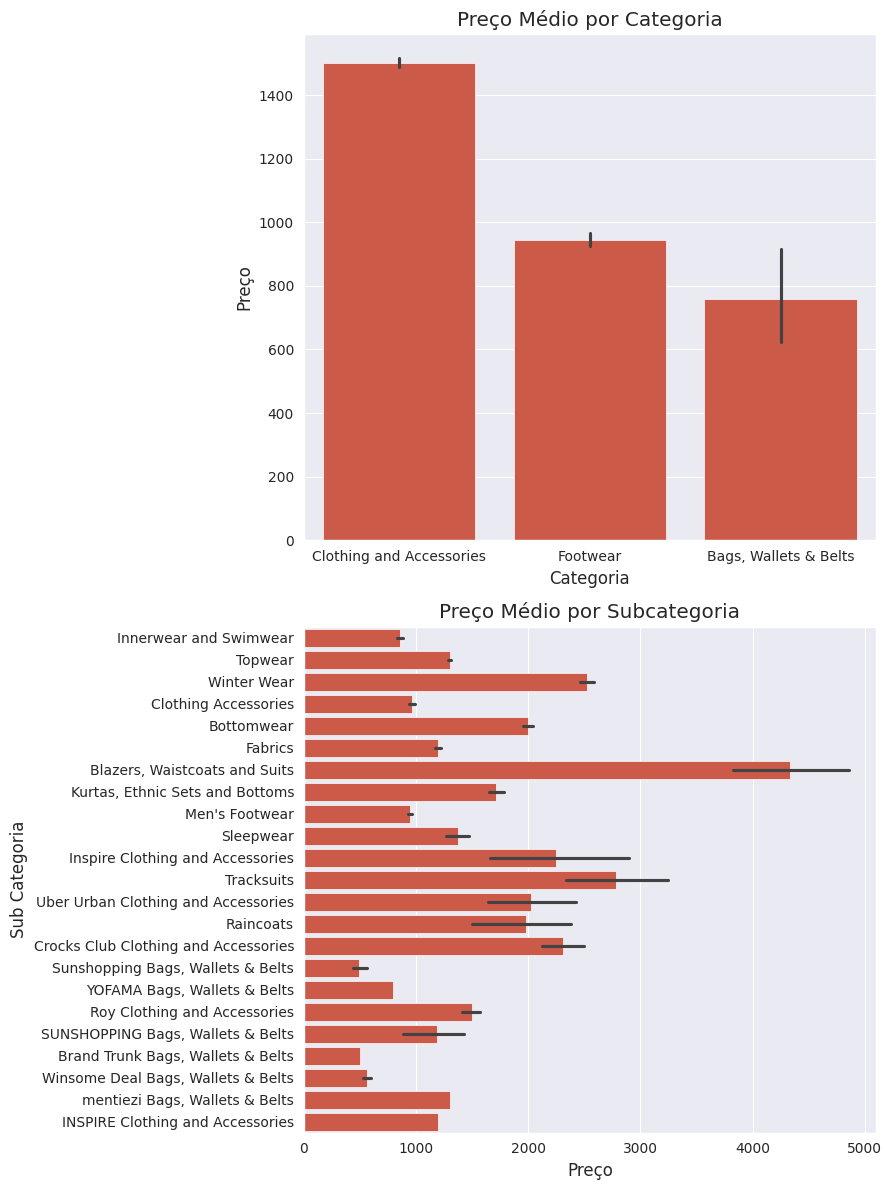

In [87]:
plt.figure(figsize=(9,12))

plt.subplot(2,1,1)
sns.barplot(df1, x='category', y='actual_price')
plt.title('Preço Médio por Categoria')
plt.xlabel("Categoria")
plt.ylabel("Preço")

plt.subplot(2,1,2)
sns.barplot(df1, x='actual_price', y='sub_category', orient='horizontal')
plt.title('Preço Médio por Subcategoria')
plt.xlabel("Preço")
plt.ylabel("Sub Categoria")


plt.tight_layout()

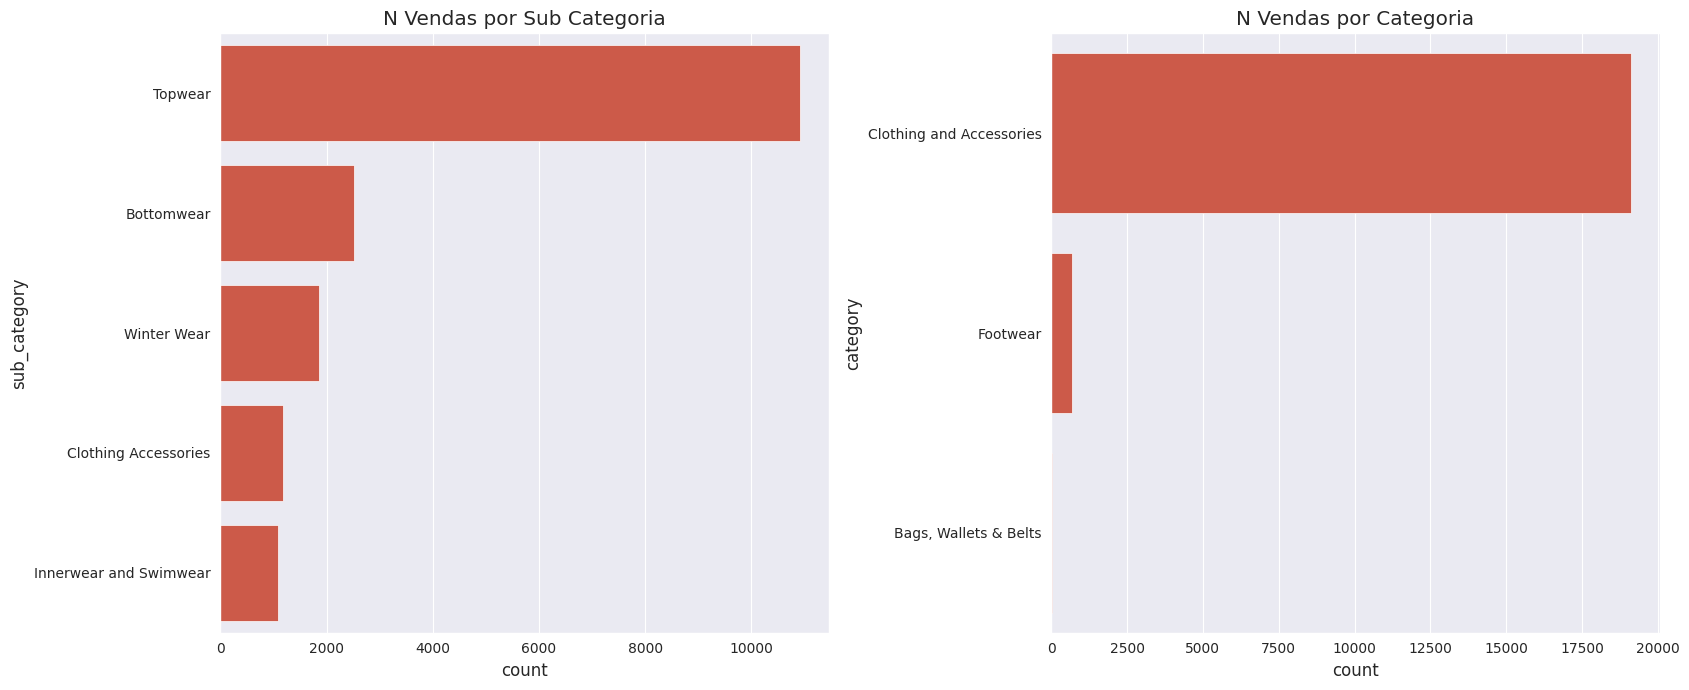

In [109]:
plt.figure(figsize=(17,7))

plt.subplot(1,2,1)
top5_subcat = df1['sub_category'].value_counts().iloc[:5]
top5_subcat = pd.DataFrame(top5_subcat)
sns.barplot(top5_subcat,x='count', y='sub_category', orient='horizontal')
plt.title("N Vendas por Sub Categoria")

plt.subplot(1,2,2)
top3_cat = df1['category'].value_counts()
top3_cat = pd.DataFrame(top3_cat)
sns.barplot(top3_cat, x='count', y='category', orient='horizontal')
plt.title("N Vendas por Categoria")

plt.tight_layout()
#top_subcat_df = df1.loc[df1['sub_category'].isin(top10_subcat),:]
#sns.barplot(top_subcat_df, y='sub_category', x='actual_price', orient='horizontal')
#plt.title("Top 5 Sub Categorias")
#plt.xlabel("Preço")
#plt.ylabel("Sub Categoria")

<Axes: xlabel='is_fit', ylabel='actual_price'>

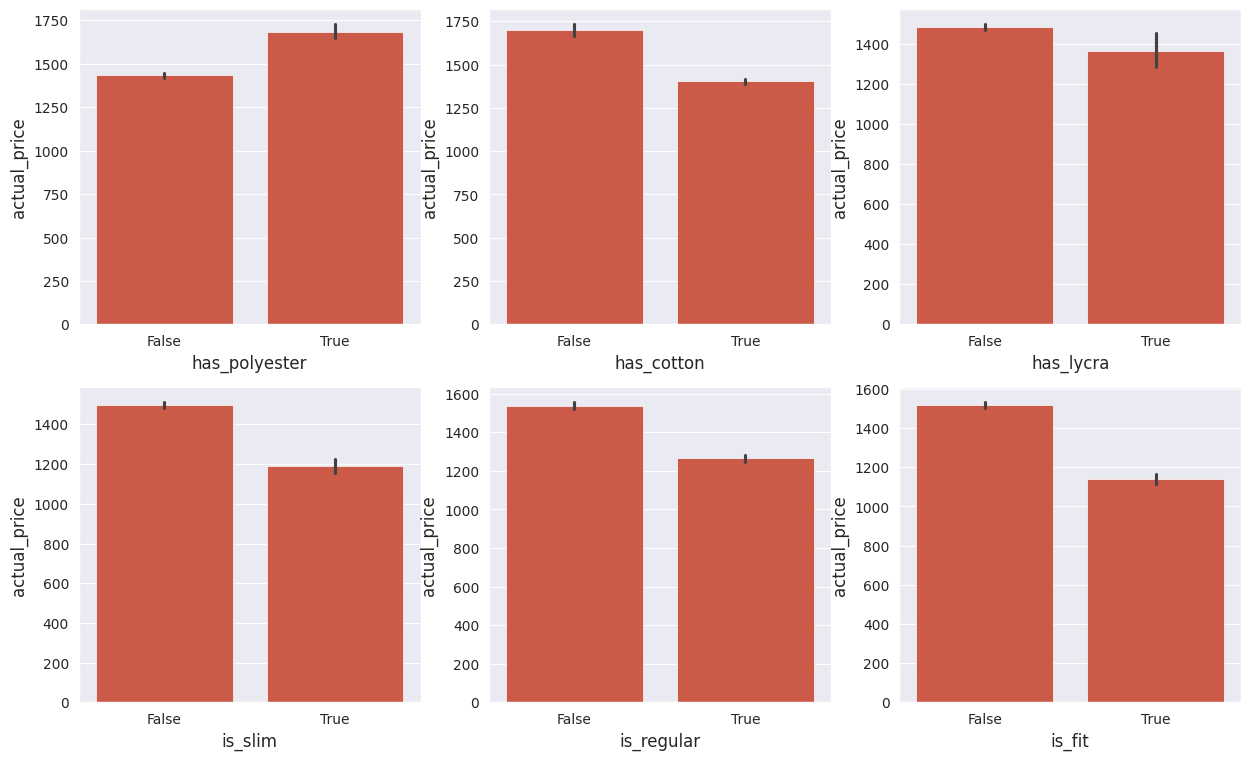

In [57]:
plt.figure(figsize=(15,9))


plt.subplot(2,3,1)
sns.barplot(df1, y='actual_price', x='has_polyester')

plt.subplot(2,3,2)
sns.barplot(df1, y='actual_price', x='has_cotton')

plt.subplot(2,3,3)
sns.barplot(df1, y='actual_price', x='has_lycra')

plt.subplot(2,3,4)
sns.barplot(df1, y='actual_price', x='is_slim')

plt.subplot(2,3,5)
sns.barplot(df1, y='actual_price', x='is_regular')

plt.subplot(2,3,6)
sns.barplot(df1, y='actual_price', x='is_fit')

Text(0, 0.5, 'País de Origem')

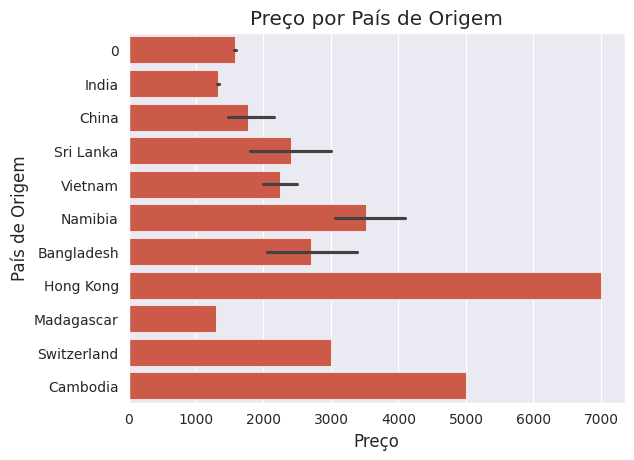

In [84]:
sns.barplot(df1, y='Country of Origin', x='actual_price', orient='horizontal')
plt.title("Preço por País de Origem")
plt.xlabel("Preço")
plt.ylabel("País de Origem")


Text(0.5, 1.0, 'Matriz de Correlação Variáveis Numéricas')

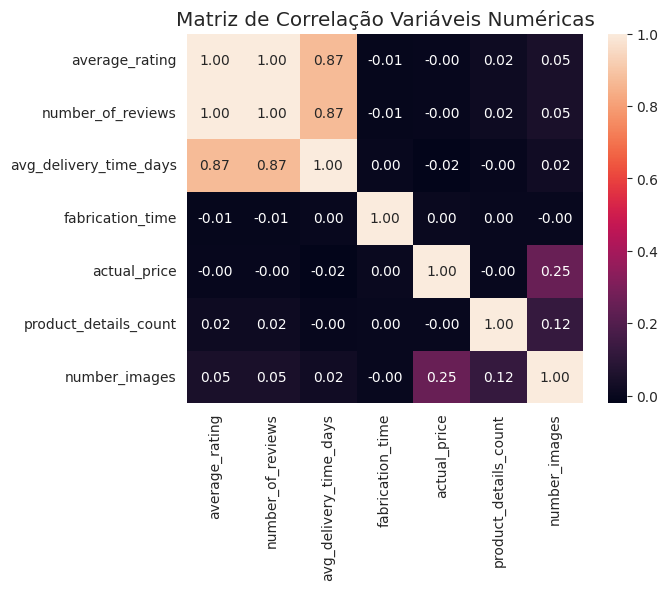

In [85]:
sns.heatmap(numerical_feat.corr(), annot=True, fmt='.2f')
plt.title("Matriz de Correlação Variáveis Numéricas")

In [81]:
top10_brands = df1['brand'].value_counts().iloc[:10].index
top_df = df1.loc[df1['brand'].isin(top10_brands),:]

Text(0, 0.5, 'Marca')

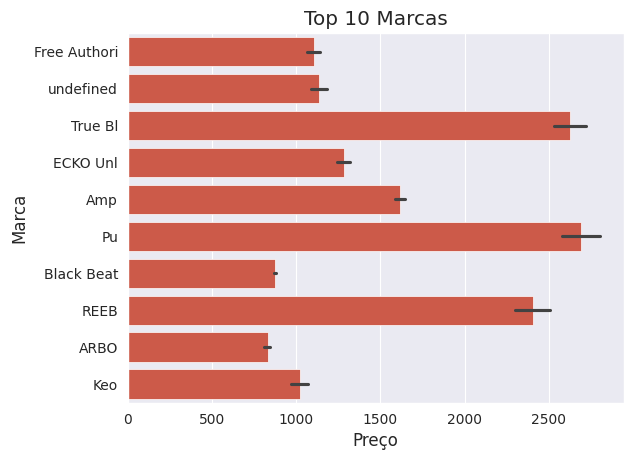

In [86]:
sns.barplot(top_df, y='brand', x='actual_price', orient='horizontal')
plt.title("Top 10 Marcas")
plt.xlabel("Preço")
plt.ylabel("Marca")

## Filtrar Colunas

In [60]:
cols_drop = ['_id','crawled_at','description','title']
df1 = df1.drop(cols_drop, axis=1)

# 4.0 Pre Processing

In [61]:
X = df1.drop(['pid','actual_price'], axis=1).copy()
y = df1['actual_price'].copy()

In [62]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## 4.1 One-Hot Encoding

In [63]:
#ONE HOT ENCODER
onehot = ['category','out_of_stock']
X_train = pd.get_dummies(X_train, columns=onehot)
X_val = pd.get_dummies(X_val, columns=onehot)

In [64]:
X_train.shape, X_val.shape

((15850, 43), (3963, 43))

## 4.2 Target Encoding

In [65]:


#TARGET ENCODER
te_cols = ['brand','seller','sub_category',"Fabric",
                        "Fabric Care",
                        "Hooded",
                        "Pockets",
                        "Pack Of",
                        "Secondary Color",
                        "Style Code",
                        "Ideal For",
                        "Reversible",
                        "Neck",
                        "Generic Name",
                        "Brand Fit",
                        "Pattern",
                        "Sleeve",
                        "Country of Origin",
                        "Size",
                        "Fit",
                        "Number of Contents in Sales Package",
                        "Suitable For",
                        "Occasion",
                        "Color",
                        "Neck Type",
                        "Type"]


X_train[te_cols] = X_train[te_cols].astype(str)
X_val[te_cols] = X_val[te_cols].astype(str)


te = TargetEncoder(target_type='continuous')
X_train[te_cols] = te.fit_transform(X_train[te_cols], y_train)
X_val[te_cols] = te.transform(X_val[te_cols])





## 4.3 Log Transform

<Axes: xlabel='actual_price', ylabel='Count'>

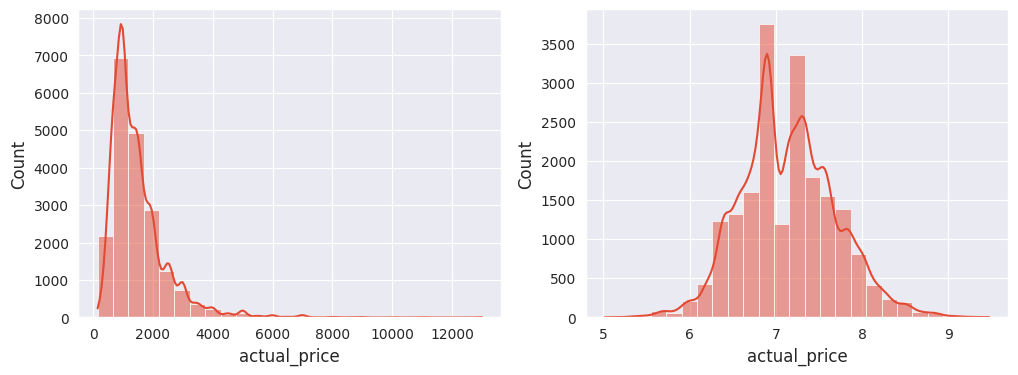

In [66]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(df1['actual_price'], kde=True, bins=25)

plt.subplot(1,2,2)
sns.histplot(np.log1p(df1['actual_price']), kde=True, bins=25)

In [67]:
#normalizar y
y = np.log1p( y )
y_train = np.log1p( y_train )
y_val = np.log1p( y_val )

## 4.4 Feature Importance

In [68]:
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

In [69]:
X_full.shape

(19813, 43)

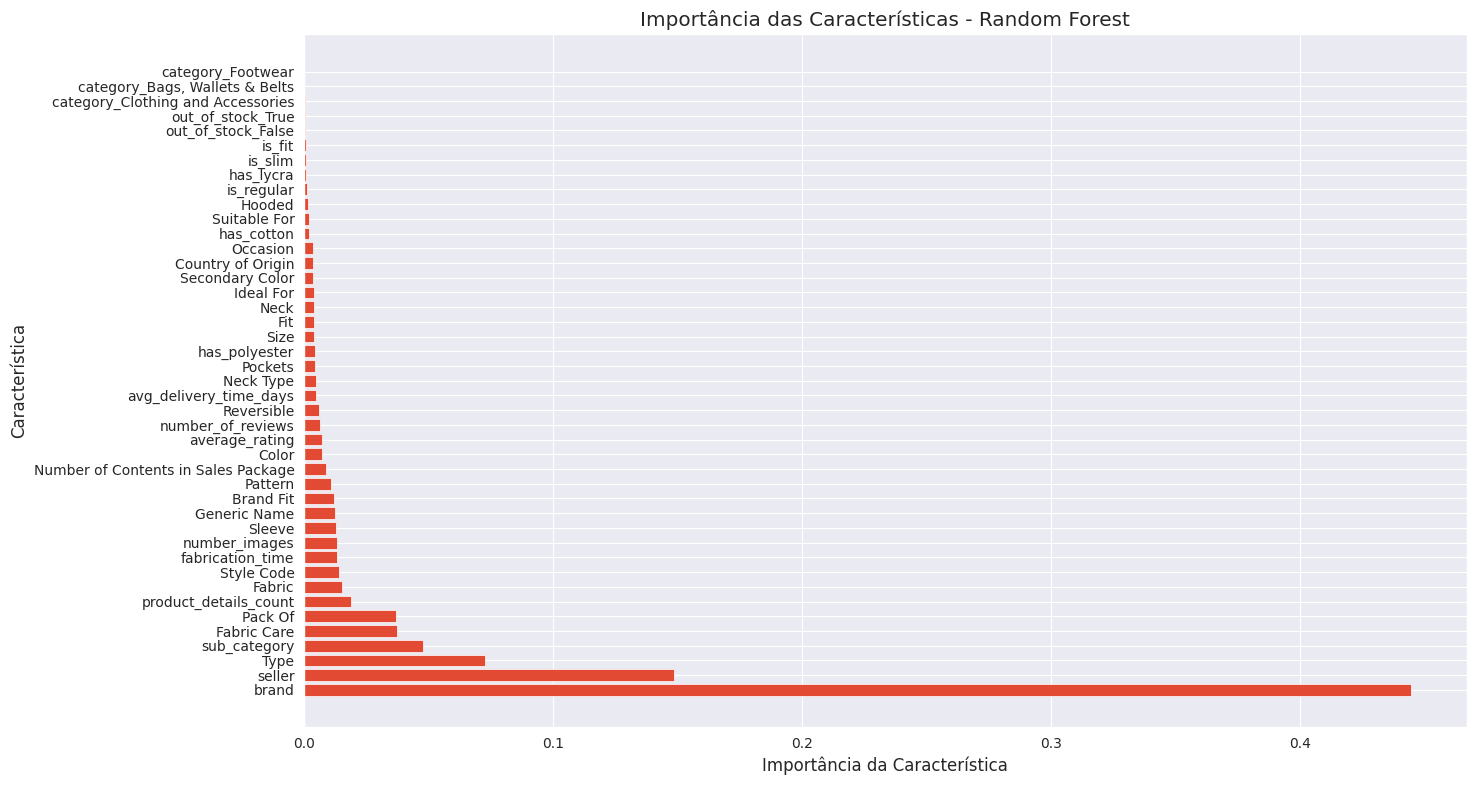

In [70]:
from sklearn.ensemble import RandomForestRegressor

# Crie o modelo Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1) 

# Treine o modelo
rf.fit(X_full, y_full)

# Obtenha a importância das características
feature_importance = rf.feature_importances_

# Crie um DataFrame para facilitar a visualização
feature_importance_df = pd.DataFrame({'Feature': X_full.columns, 'Importance': feature_importance})

# Classifique as características com base na importância
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Crie o gráfico de barras
plt.figure(figsize=(15, 9))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importância da Característica')
plt.ylabel('Característica')
plt.title('Importância das Características - Random Forest')
plt.show()

In [42]:
# # Coloquei nesse ponto para poder treinar KMEANS sobre todo o DataFrame X

# # A ideia aqui é definir os cluster e...
# # ...usar o resultado como nova FEATURE do problema principal.

# # SEARCH FOR BEST NUMBER OF CLUSTERS

# # X_kmeans = X.loc[ :, ['brand_log', 'seller', 'Type'] ]  # >>> BEST - N.Cluster=58  Silhouette=0.572461
#                                                           # >>> BEST - N.Cluster=65  Silhouette=0.579603

# # X_kmeans = X.loc[ :, ['brand_log', 'seller', 'Type', 'sub_category'] ]
#     # >>> BEST - N.Cluster=56  Silhouette=0.534592
#     # >>> BEST - N.Cluster=68  Silhouette=0.547342

# # X_kmeans = X.loc[ :, ['brand_log', 'sub_category'] ]
#     # >>> BEST - N.Cluster=8  Silhouette=0.932652

# # X_kmeans = X.loc[ :, ['brand_log', 'Type'] ]
#     # >>> BEST - N.Cluster=7  Silhouette=0.857594



# X_kmeans = X.loc[ :, ['brand', 'sub_category', 'Type'] ]
#     # >>> BEST - N.Cluster=16  Silhouette=0.826101


# n_clusters = np.arange( 14, 18, 1 )
# #n_clusters = [ 8 ]
# best_ss = 0
# best_k = 0
# best_kmeans_model = None
# first_time = True
# ss_list = []
# for c in n_clusters:

#     # define model
#     kmeans = ct.KMeans( 
#         n_clusters=c, 
#         init='random', 
#         n_init=10, 
#         random_state=0
#     )

#     # FIT & PREDICT
#     labels = kmeans.fit_predict( X_kmeans )

#     # performance (the bigger, the better)
#     ss_avg = mt.silhouette_score( X_kmeans, labels)
#     ss_list.append( ss_avg )

#     # Compare result
#     if first_time or ss_avg > best_ss:
#         first_time = False
#         best_ss = ss_avg
#         best_k = c
#         best_kmeans_model = kmeans
#         print(">>> BEST - N.Cluster={}  Silhouette={:.6f}".format(best_k, best_ss))

#     print( "n_clusters={}  - The Avg SS: {}".format( c, ss_avg ) )

# print('---- BEST RESULT ---')
# print("Number of Cluster={}  Silhouette={:.6f}".format(best_k, best_ss))

# plt.plot( n_clusters, ss_list, marker='o' )
# plt.xlabel( 'Número de Clusters K' )
# plt.ylabel( 'Silhouette Score Average' )
# print( best_kmeans_model )

# # Monta a variável KMEANS e inclui em X_train
# X['kmeans'] = best_kmeans_model.labels_

# # Inclui KMEANS em X_test_2
# X_kmeans = X_test_2.loc[ :, ['brand', 'sub_category', 'Type'] ]
# X_test_2['kmeans'] = best_kmeans_model.predict( X_kmeans )
# X_test_2['kmeans']


In [43]:
# # Coloquei nesse ponto para poder treinar KMEANS sobre todo o DataFrame X

# # A ideia aqui é definir os cluster e...
# # ...usar o resultado como nova FEATURE do problema principal.

# # SEARCH FOR BEST NUMBER OF CLUSTERS

# # X_kmeans = X.loc[ :, ['brand_log', 'seller', 'Type'] ]  # >>> BEST - N.Cluster=58  Silhouette=0.572461
#                                                           # >>> BEST - N.Cluster=65  Silhouette=0.579603

# X_kmeans = X.loc[ :, ['average_rating','Sleeve'] ]
#     # >>> BEST - N.Cluster=56  Silhouette=0.534592
#     # >>> BEST - N.Cluster=68  Silhouette=0.547342

# # X_kmeans = X.loc[ :, ['brand_log', 'sub_category'] ]
#     # >>> BEST - N.Cluster=8  Silhouette=0.932652

# # X_kmeans = X.loc[ :, ['brand_log', 'Type'] ]
#     # >>> BEST - N.Cluster=7  Silhouette=0.857594

# import sklearn.cluster as ct
# import sklearn.metrics as mt

# #X_kmeans = X.loc[ :, ['brand', 'sub_category', 'Type'] ]
#     # >>> BEST - N.Cluster=16  Silhouette=0.826101


# n_clusters = np.arange( 63, 70, 1 )
# #n_clusters = [ 8 ]
# best_ss = 0
# best_k = 0
# best_kmeans_model = None
# first_time = True
# ss_list = []
# for c in n_clusters:

#     # define model
#     kmeans = ct.KMeans( 
#         n_clusters=c, 
#         init='random', 
#         n_init=10, 
#         random_state=0
#     )

#     # FIT & PREDICT
#     labels = kmeans.fit_predict( X_kmeans )

#     # performance (the bigger, the better)
#     ss_avg = mt.silhouette_score( X_kmeans, labels)
#     ss_list.append( ss_avg )

#     # Compare result
#     if first_time or ss_avg > best_ss:
#         first_time = False
#         best_ss = ss_avg
#         best_k = c
#         best_kmeans_model = kmeans
#         print(">>> BEST - N.Cluster={}  Silhouette={:.6f}".format(best_k, best_ss))

#     print( "n_clusters={}  - The Avg SS: {}".format( c, ss_avg ) )

# print('---- BEST RESULT ---')
# print("Number of Cluster={}  Silhouette={:.6f}".format(best_k, best_ss))

# plt.plot( n_clusters, ss_list, marker='o' )
# plt.xlabel( 'Número de Clusters K' )
# plt.ylabel( 'Silhouette Score Average' )
# print( best_kmeans_model )

# # Monta a variável KMEANS e inclui em X_train
# X['kmeans2'] = best_kmeans_model.labels_

# # Inclui KMEANS em X_test_2
# X_kmeans = X_test_2.loc[ :, ['average_rating','Sleeve' ]]
# X_test_2['kmeans2'] = best_kmeans_model.predict( X_kmeans )
# X_test_2['kmeans2']


# 5.0 Machine Learning

In [76]:
X_train.columns = X_train.columns.map(lambda x: inflection.parameterize(x, separator='_'))
X_val.columns = X_val.columns.map(lambda x: inflection.parameterize(x, separator='_'))
X_full.columns = X_full.columns.map(lambda x: inflection.parameterize(x, separator='_'))

## XGBoost

In [77]:
from xgboost import XGBRegressor

xgb = XGBRegressor()

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [78]:
y_pred_val = xgb.predict(X_val)

In [79]:
xgb_metrics = compute_metrics('XGBoost', y_pred_val, y_val)

## Catboost

In [80]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(verbose=False)

cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_val)

In [81]:
cat_metrics = compute_metrics('CatBoost',y_pred_cat, y_val)

## LightGBM

In [82]:
from lightgbm import LGBMRegressor

lgb = LGBMRegressor()

lgb.fit(X_train, y_train)

y_pred_lgb = lgb.predict(X_val)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3083
[LightGBM] [Info] Number of data points in the train set: 15850, number of used features: 42
[LightGBM] [Info] Start training from score 7.138322


In [83]:
lgb_metrics = compute_metrics('LightGBM',y_pred_lgb, y_val)

## Random Forest

In [84]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_jobs=-1, random_state=58)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)

In [85]:
rf_metrics = compute_metrics('RandomForest',y_pred_rf, y_val)

In [86]:
from sklearn.ensemble import VotingRegressor

voting_reg = VotingRegressor(
    estimators=[
        ('random_forest', rf),
        ('catboost', cat),
        ('xgboost', xgb),
        ('lighgbm', lgb),
        
    ]
)

voting_reg.fit(X_train, y_train)
y_pred_vot = voting_reg.predict(X_val)
ensenble_metrics = compute_metrics('VotingRegressor', y_pred_vot, y_val)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3083
[LightGBM] [Info] Number of data points in the train set: 15850, number of used features: 42
[LightGBM] [Info] Start training from score 7.138322


### Metrics

In [352]:
pd.concat([xgb_metrics, lgb_metrics, cat_metrics, rf_metrics, ensenble_metrics]).sort_values(by='SMAPE').reset_index(drop=True)

,Model,MAE,MAPE,RMSE,SMAPE
0,RandomForest,171.123048,0.107444,395.864516,10.285424
1,VotingRegressor,192.615309,0.125049,385.141079,12.061579
2,XGBoost,203.765945,0.132715,410.079549,12.730710
3,CatBoost,209.372415,0.137897,386.011682,13.325583
4,LightGBM,218.942058,0.144922,403.090771,13.986653


In [87]:
pd.concat([xgb_metrics, lgb_metrics, cat_metrics, rf_metrics, ensenble_metrics]).sort_values(by='SMAPE').reset_index(drop=True)


,Model,MAE,MAPE,RMSE,SMAPE
0,RandomForest,167.681988,0.107177,386.499751,10.193722
1,VotingRegressor,193.744480,0.127053,387.856941,12.174611
2,XGBoost,206.764630,0.136074,407.179064,12.990901
3,CatBoost,210.386921,0.140185,389.481376,13.448476
4,LightGBM,219.643058,0.145146,415.329657,13.911491


In [362]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 58,
 'verbose': 0,
 'warm_start': False}

## Fine Tuning Optuna

In [357]:
import optuna

In [374]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 1500, 25),
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        
    }
    # Crie o modelo Random Forest com os parâmetros otimizados
    model = RandomForestRegressor(**params, n_jobs=-1, random_state=58)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    smape_error = smape(np.expm1(y_pred), np.expm1(y_val))
    
    return smape_error

In [375]:
study = optuna.create_study(direction='minimize')

study.optimize(objective, n_trials=20)

[I 2023-10-23 14:54:32,001] A new study created in memory with name: no-name-a3201b9f-f0ee-4816-a69e-d0515288396e
[I 2023-10-23 14:54:38,118] Trial 0 finished with value: 10.198536561263573 and parameters: {'n_estimators': 475}. Best is trial 0 with value: 10.198536561263573.
[I 2023-10-23 14:54:43,514] Trial 1 finished with value: 10.202740380966524 and parameters: {'n_estimators': 425}. Best is trial 0 with value: 10.198536561263573.
[I 2023-10-23 14:54:53,257] Trial 2 finished with value: 10.188751775349798 and parameters: {'n_estimators': 775}. Best is trial 2 with value: 10.188751775349798.
[I 2023-10-23 14:55:05,158] Trial 3 finished with value: 10.188871359628873 and parameters: {'n_estimators': 950}. Best is trial 2 with value: 10.188751775349798.
[I 2023-10-23 14:55:18,470] Trial 4 finished with value: 10.19054611135939 and parameters: {'n_estimators': 1075}. Best is trial 2 with value: 10.188751775349798.
[I 2023-10-23 14:55:30,265] Trial 5 finished with value: 10.18656644514

In [376]:
optuna_best = study.best_params
optuna_best

{'n_estimators': 875}

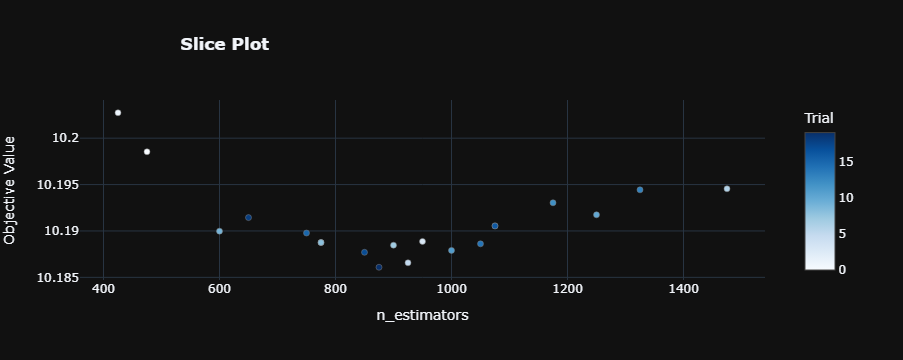

In [377]:
fig = optuna.visualization.plot_slice(study)
fig.update_layout(template='plotly_dark', title='<b>Slice Plot', title_x=0.2)

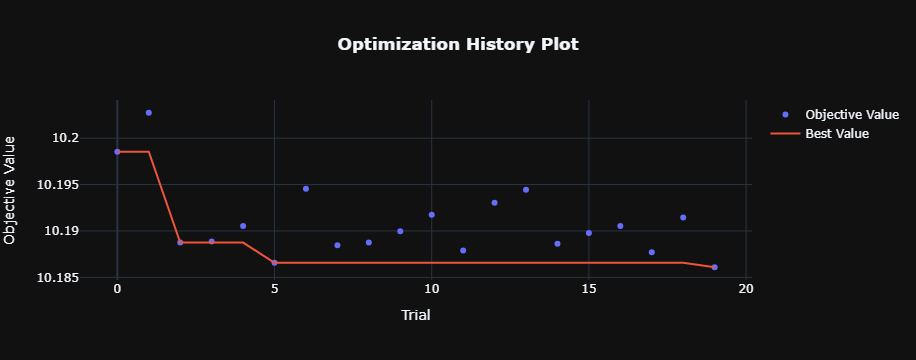

In [378]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(template='plotly_dark', title='<b>Optimization History Plot', title_x=0.5)

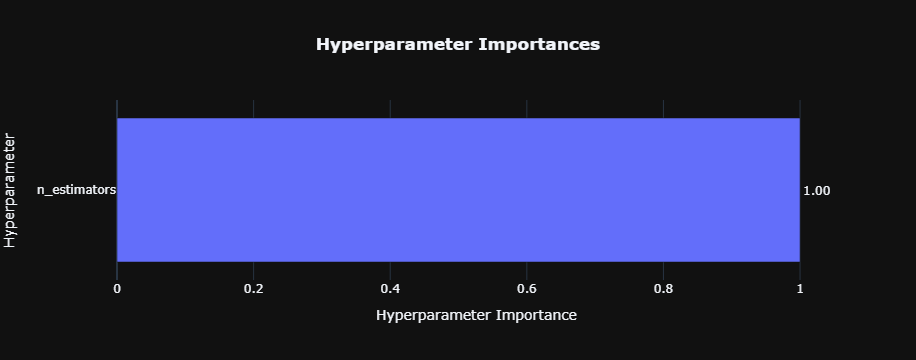

In [379]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(template='plotly_dark', title='<b>Hyperparameter Importances', title_x=0.5)

# 6.0 Previsão no Test e Submissão

In [380]:
#rf = RandomForestRegressor(n_jobs=-1, random_state=58, n_estimators=875)

In [94]:
rf.fit(X_full, y_full)

RandomForestRegressor(n_jobs=-1, random_state=58)

In [95]:
X_test_2 = pd.read_json(path + 'test.json', orient='split')

In [96]:
X_test_2 = clean_test(X_test_2)

In [97]:
y_pred_test = rf.predict(X_test_2)
y_pred_test = np.expm1(y_pred_test)

## Submission

In [101]:
make_submission(X_test_2, y_pred_test)

,pid,actual_price
0,SHTFDYZGEXPED7YS,1309.953196
1,TROFM47EVWRYK7ZU,2245.518287
2,FABFZAMPGDW3BKGX,1390.567914
3,BZRFNMGPNBQTYHMG,7346.066697
4,SHTFV5G6PZDQZEVZ,1224.060427
...,...,...
5595,TSHFHHYFYUDABZAV,1492.930337
5596,DHTFZ3WE9XGWEH3H,1029.958381
5597,BZRFZQC6NXA5QV7F,8164.252078
5598,TSHFMKUGFR6HSP7E,1139.626516


In [102]:
df_submission.to_csv('submission_hackday_6.csv', index=False)

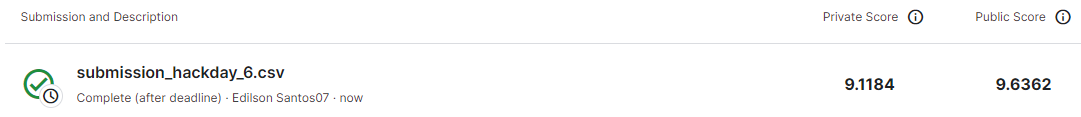

In [393]:
from IPython.display import Image
Image(filename='/home/edilson07/projects/hackday_6/notebooks/hackday_6.png')

# 7.0 Business Performance

---

## Premissas

- Vamos considerar uma loja que vende um único produto: Jaquetas de Couro.
- O custo total de cada jaqueta é de R\\$100,00.
- Após a análise de elasticidade de preço, a loja decide que o preço ideal de venda é de R\\$150,00.

## Sem a Otimização do Modelo

- Suponhamos que a loja tenha estabelecido um preço de venda de R\\$150,00 para suas jaquetas de couro.
- Sob essa precificação, a loja vende 1.000 unidades da jaqueta, totalizando R\\$150.000,00 em receita.
- O lucro resultante é de R\\$50.000,00 (R\\$150.000,00 - R$100.000,00 em custos).

## Com o Modelo

Agora, vamos introduzir a otimização de preços com base em um modelo.

- O modelo analisou a base de dados histórica e concluiu que o preço ideal para as jaquetas deveria ser de R\\$200,00.
- Com uma margem de erro de 9% (baseada no treinamento do modelo), a loja pode confiantemente definir o preço em R\\$200,00.
- Como resultado, as vendas não diminuirão significativamente; suponhamos que a loja venda cerca de 900 jaquetas a esse preço.
- O lucro resultante é de R\\$90.000,00 (R\\$200.000,00 - R$100.000,00 em custos), um aumento substancial em relação à precificação anterior.
  
### Comparação de Cenários:

Sem a otimização do modelo: Receita de R\\$150.000,00 e lucro de R\\$50.000,00.
Com o modelo de otimização: Receita de R\\$180.000,00 e lucro de R\\$90.000,00.


---